# airlines_flights_data

In [1]:
# Librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/airlines-flights-data/airlines_flights_data.csv


## **DATA CLEANING**

In [2]:
url='/kaggle/input/airlines-flights-data/airlines_flights_data.csv'
df=pd.read_csv(url,sep=',')
df

,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [3]:
print(f'Number of rows {df.shape[0]} and columns {df.shape[1]}')

Number of rows 300153 and columns 12


In [4]:
df.drop(columns=['index'], inplace=True)
df.drop(columns=['flight'], inplace=True)

In [5]:
cat=df.select_dtypes(include='object').columns
num=df.select_dtypes(include='number').columns
print(num)
print(cat)

Index(['duration', 'days_left', 'price'], dtype='object')
Index(['airline', 'source_city', 'departure_time', 'stops', 'arrival_time',
       'destination_city', 'class'],
      dtype='object')


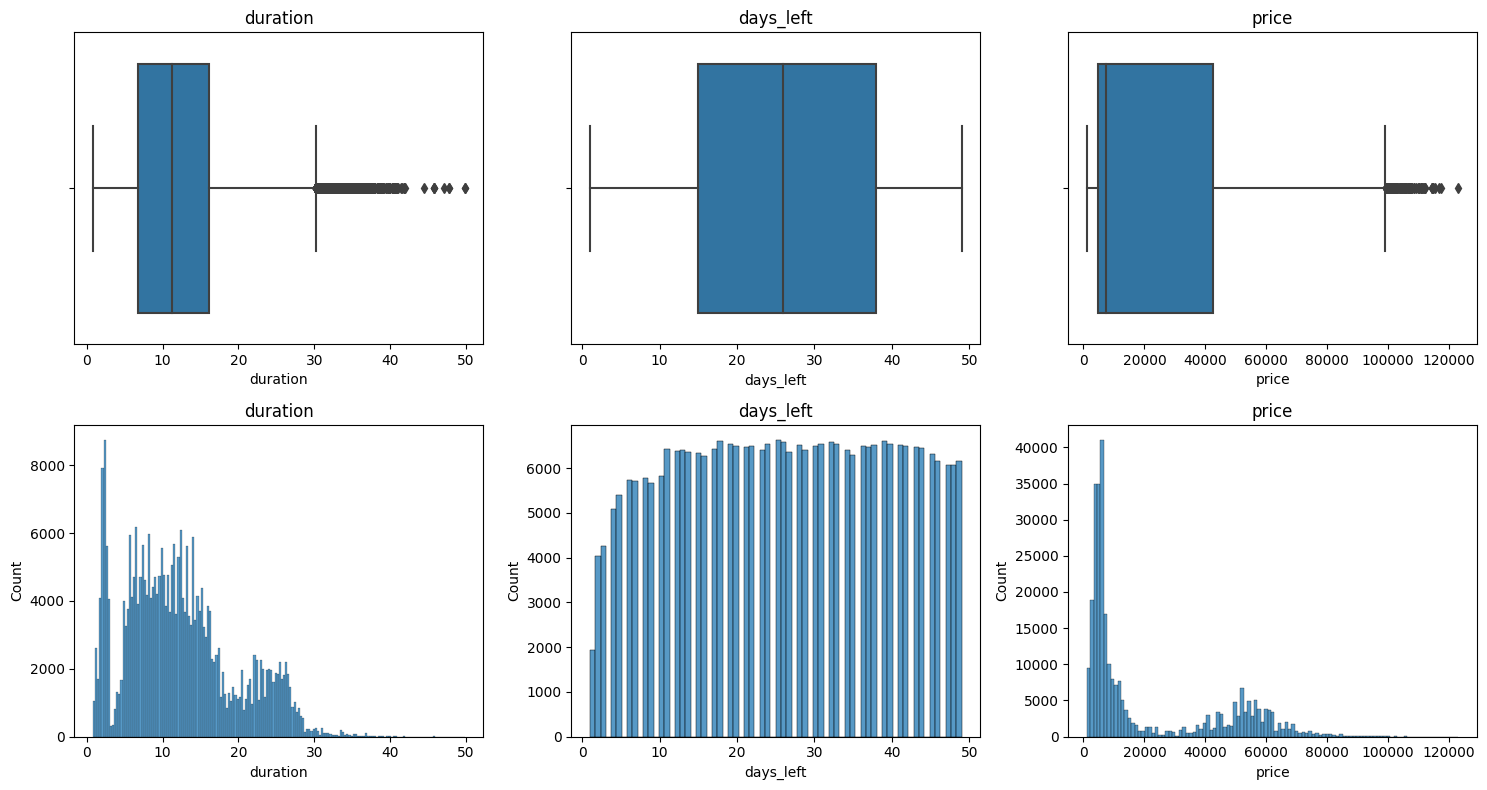

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i, ax in enumerate(axs[0]):
    if i < len(num):
        sns.boxplot(data=df, x=num[i], ax=ax)
        ax.set_title(num[i])
    else:
        ax.axis('off')

for i, ax in enumerate(axs[1]):
    if i < len(num):
        sns.histplot(data=df, x=num[i], ax=ax)
        ax.set_title(num[i])
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
for i in cat:
    print('-------------------------------')
    print(df[i].value_counts())
    print('-------------------------------')

-------------------------------
airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: count, dtype: int64
-------------------------------
-------------------------------
source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: count, dtype: int64
-------------------------------
-------------------------------
departure_time
Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: count, dtype: int64
-------------------------------
-------------------------------
stops
one            250863
zero            36004
two_or_more     13286
Name: count, dtype: int64
-------------------------------
-------------------------------
arrival_time
Night            91538
Evening          78323
Morning          62735
Afternoon        38139
Early_Morning    15417
L

In [8]:
tabla_uniques = pd.DataFrame({col: [df[col].nunique()] for col in cat}, index=['Valores únicos']).T
print(tabla_uniques)

                  Valores únicos
airline                        6
source_city                    6
departure_time                 6
stops                          3
arrival_time                   6
destination_city               6
class                          2


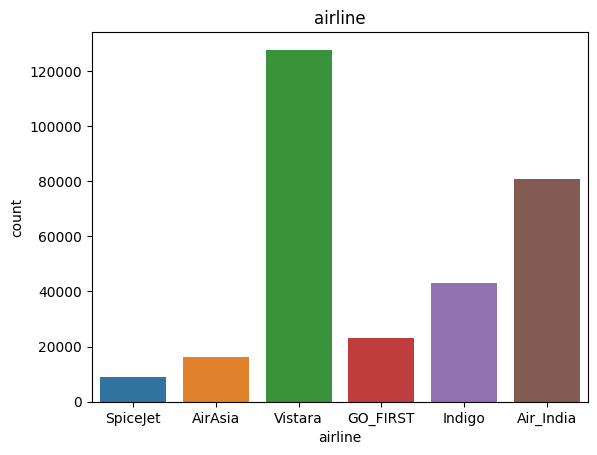

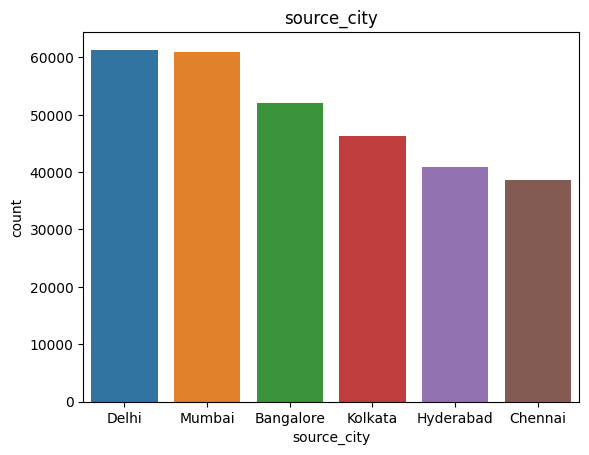

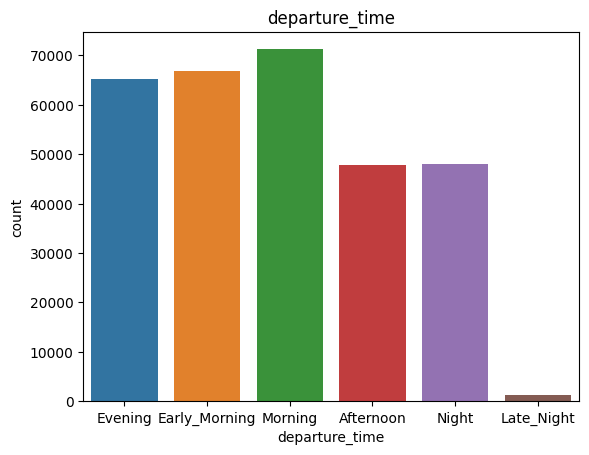

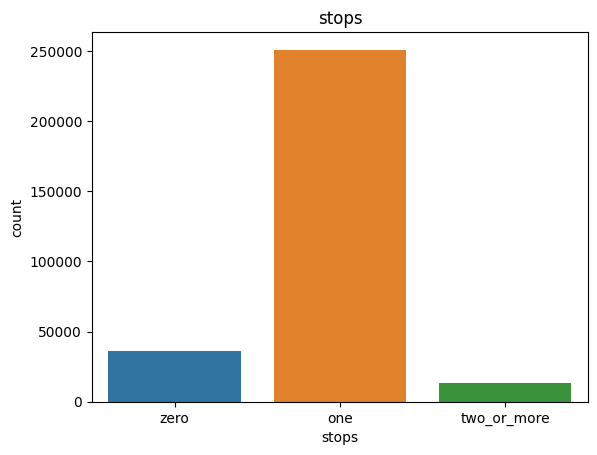

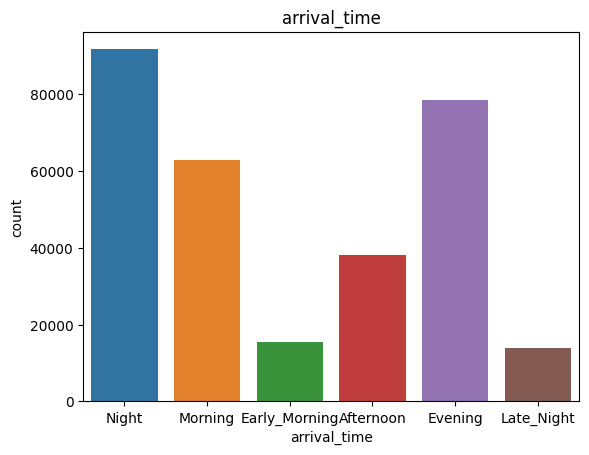

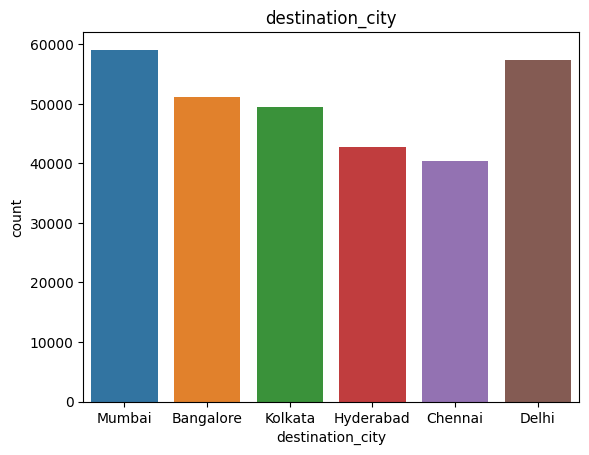

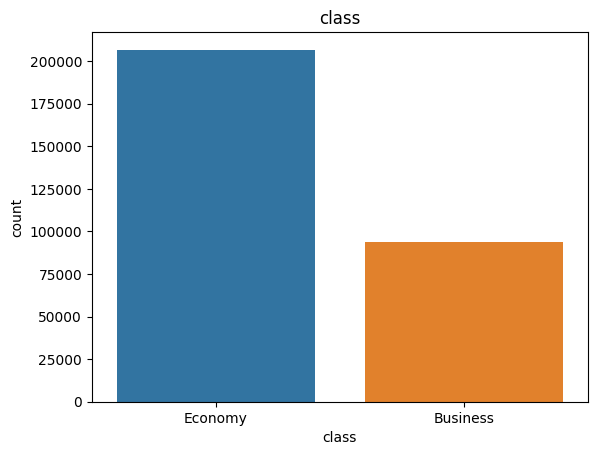

In [9]:
for i in cat:
    sns.countplot(data=df,x=i)
    plt.title(i)
    plt.show()

## **DATA PREPROCESSING**

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cat_1=['class','stops']
for col in cat_1:
    df[col] = le.fit_transform(df[col])

In [11]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
cat_2=['airline','source_city', 'departure_time','arrival_time',
       'destination_city']
df_ohe = pd.DataFrame(ohe.fit_transform(df[cat_2]), columns=ohe.get_feature_names_out(cat_2))

df = pd.concat([df.drop(cat_2, axis=1), df_ohe], axis=1)

In [12]:
from sklearn.model_selection import train_test_split

# Variables independientes (todas menos 'price')
X = df.drop(columns=['price'])

# Variable dependiente
y = df['price']

# Dividir en entrenamiento y prueba (80% - 20% por ejemplo)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,     # 20% para test
    random_state=42    # para reproducibilidad
)

print("Tamaño entrenamiento:", X_train.shape, y_train.shape)
print("Tamaño prueba:", X_test.shape, y_test.shape)


Tamaño entrenamiento: (240122, 34) (240122,)
Tamaño prueba: (60031, 34) (60031,)


## **MODEL BUILDING**

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Dividir train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# ==========================
# 2. Random Forest
# ==========================
rf = RandomForestRegressor()

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

grid_rf = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid_rf, 
    scoring='r2', 
    cv=5, 
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

# Mejor modelo RF
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Mejor modelo RF:", grid_rf.best_params_)
print("R² RF:", r2_score(y_test, y_pred_rf))
print("RMSE RF:", mean_squared_error(y_test, y_pred_rf, squared=False))

Mejor modelo RF: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 200}
R² RF: 0.9849395095243001
RMSE RF: 2786.290701178928


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error

mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
mape = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100
medae = median_absolute_error(y_test, y_pred_rf)

print(f"R²: {r2_score(y_test, y_pred_rf):.4f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MedAE: {medae:.2f}")


R²: 0.9849
MAE: 1257.16
MSE: 7763415.87
RMSE: 2786.29
MAPE: 8.51%
MedAE: 403.85


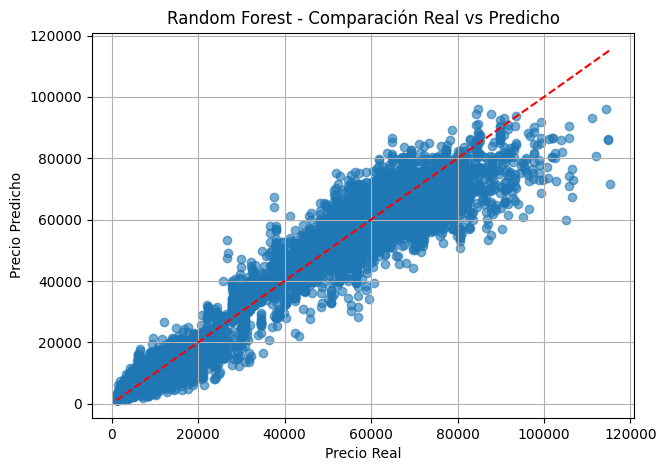

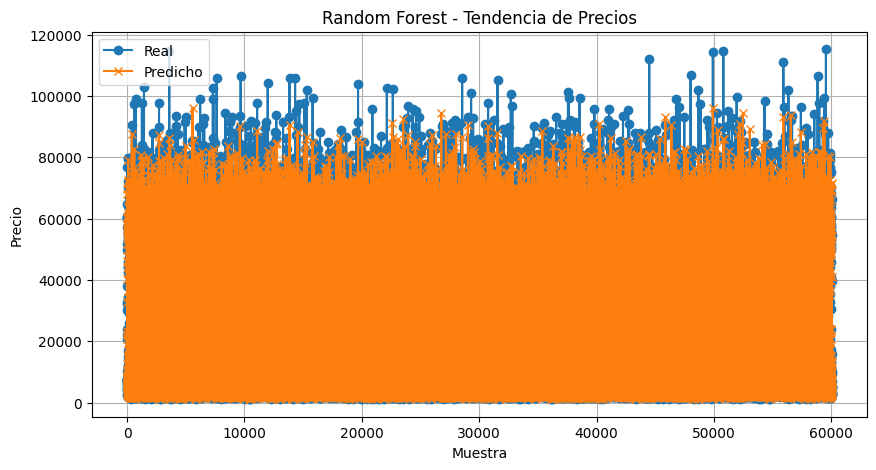

In [15]:
# =====================
# 1. Scatter plot
# =====================
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Random Forest - Comparación Real vs Predicho")
plt.grid(True)
plt.show()

# =====================
# 2. Comparación de tendencia
# =====================
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(y_test)), y_test.values, label="Real", marker='o')
plt.plot(np.arange(len(y_test)), y_pred_rf, label="Predicho", marker='x')
plt.xlabel("Muestra")
plt.ylabel("Precio")
plt.title("Random Forest - Tendencia de Precios")
plt.legend()
plt.grid(True)
plt.show()


# **Conclusiones**

El modelo de regresión obtuvo un R² de 0.9849, lo que indica que explica el 98.49% de la variabilidad de los precios.
El error absoluto promedio (MAE) fue de 1,251.80 unidades monetarias, mientras que el error cuadrático medio (MSE) fue de 7,772,665.63.
El RMSE se situó en 2,787.95, lo que significa que, penalizando más los errores grandes, el modelo presenta una desviación promedio de aproximadamente 2,788 unidades monetarias.
El MAPE fue de 8.49%, indicando que, en promedio, el error relativo de las predicciones es del 8.49%.
Finalmente, el MedAE fue de 401.63, lo que implica que la mitad de las predicciones tiene un error menor a 402 unidades monetarias.